<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLGameDrives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the library for NFL Data
!pip install nfl_data_py
import nfl_data_py as nfl

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import axes
from matplotlib.ticker import FuncFormatter
import numpy as np
from PIL import Image

#import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from google.colab import drive

drive.mount('/content/drive', force_remount=False)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=4534dfdf9cf9cfd74a22486bbe51c555a86c28dd64d159f6965a02d3934b0ad9
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py
Mounted at /content/drive


In [ ]:
gm = nfl.import_pbp_data([2023])
pd.set_option('display.max_columns', None)
gm = gm[gm["game_id"] == "2023_03_LAC_MIN"]

gm.head(30)

In [ ]:
lac_min = gm[["posteam","play_type", "drive", "qtr", "time", "yardline_100", "ydsnet", "drive_end_transition"]]

# lac_min = lac_min[(lac_min["play_type"] == "pass") | (lac_min["play_type"] == "run") | (lac_min["play_type"] == "no_play")]
lac_min = lac_min[lac_min['play_type'] != "kickoff"]
lac_min = lac_min[lac_min['play_type'] != "extra_point"]

lac_min = lac_min.sort_values(by = ["qtr","time"], ascending = [True, False]).reset_index(drop = True)

drive_start = lac_min.groupby('drive').first().reset_index()
drive_end = lac_min.groupby('drive').last().reset_index()

drive = pd.merge(drive_start, drive_end, on=['drive'])

drive = drive.rename(columns={'qtr_x': 'qtr',
  'posteam_x': 'posteam',
  'yardline_100_y': 'yardline_end',
  'yardline_100_x': 'yardline_start',
  'drive_end_transition_x': 'drive_result'})

drive_final = drive[["drive", "posteam", "qtr", "yardline_start", "yardline_end", "drive_result"]]

drive_final.loc[drive_final['drive_result'] == "TOUCHDOWN", ['yardline_end']] = 0

qtr_drive = drive_final.groupby('qtr').last().reset_index()

drive_final.head(24)

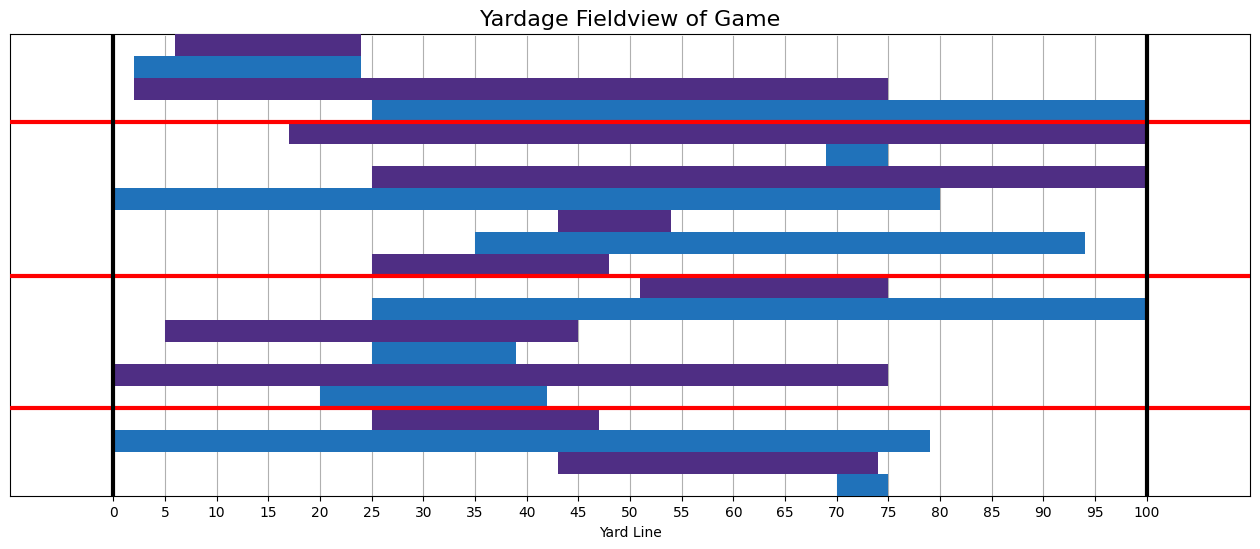

In [152]:
teamcolor = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

tm_colors = [teamcolor.get(team) for team in drive_final["posteam"]]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 6))

field_width = (len(drive_final["drive"])-1) * 4 - 2
field_length = 100

# Set the background color to green
# ax.set_facecolor('green')

# Plot the field
plt.plot([0, 0, field_length, field_length], [0, field_width, field_width, 0], color='white', lw=2)
plt.xlim(-10, field_length+ 10)
plt.ylim(-2, field_width)

# len(drive_final["drive"])
for i in range(len(drive_final["drive"])):
  if drive_final["qtr"][i] % 2 != 0:

    if (drive_final["posteam"][i] == "LAC"):
      plt.barh(4*i, drive_final["yardline_end"][i]  -  drive_final["yardline_start"][i], left=drive_final["yardline_start"][i], height=4, color=tm_colors[i], zorder = 10)

    if (drive_final["posteam"][i] == "MIN"):
      plt.barh(4*i, drive_final["yardline_start"][i] -  drive_final["yardline_end"][i], left=(100-drive_final["yardline_start"][i]), height=4, color=tm_colors[i], zorder = 10)

  if drive_final["qtr"][i] % 2 == 0:

    if (drive_final["posteam"][i] == "LAC"):
      plt.barh(4*i, drive_final["yardline_start"][i] -  drive_final["yardline_end"][i], left=(100-drive_final["yardline_start"][i]), height=4, color=tm_colors[i], zorder = 10)

    if (drive_final["posteam"][i] == "MIN"):
      plt.barh(4*i, drive_final["yardline_end"][i] -  drive_final["yardline_start"][i], left=drive_final["yardline_start"][i], height=4, color=tm_colors[i], zorder = 10)

# Split quarters
for i in range(len(qtr_drive["qtr"])-1):
  plt.axhline(qtr_drive["drive"][i]* 4-2, color='r', linewidth = 3, zorder = 15)

plt.axvline(0, color='k', linewidth = 3, zorder = 15)
plt.axvline(100, color='k', linewidth = 3, zorder = 15)

# Title
ax.set_title('Yardage Fieldview of Game', fontsize=16)

# Add labels
plt.xlabel("Yard Line")

plt.xticks(np.arange(0, 105, 5))
plt.yticks([])

plt.grid(True)

# Display the field
plt.show()